# Imports

In [203]:
import os
import sys
from pathlib import Path
import argparse
import pandas as pd
from skimage.morphology import skeletonize, medial_axis
from skimage.measure import label, regionprops
from skimage.util import invert
from math import atan2, degrees
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

# Ensure CUDA DLLs are found on Windows
env = sys.exec_prefix  # e.g. your conda environment prefix
bin_dir = os.path.join(env, "Library", "bin")
if os.path.isdir(bin_dir):
    os.add_dll_directory(bin_dir)
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import cv2
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader

# Vessel Extraction Model Deffinition and Helpers

In [ ]:
# simple U-Net (5 levels)
def C(in_ch, out_ch):  # conv-block
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = C(3,   32)
        self.d2 = C(32,  64)
        self.d3 = C(64, 128)
        self.d4 = C(128,256)
        self.mid= C(256,512)
        self.u4 = C(512+256,256)
        self.u3 = C(256+128,128)
        self.u2 = C(128+64 ,64)
        self.u1 = C(64 +32 ,32)
        self.out= nn.Conv2d(32,1,1)

        self.pool = nn.MaxPool2d(2)
        self.up   = lambda x: nn.functional.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)

    def forward(self,x):
        d1 = self.d1(x); p1 = self.pool(d1)
        d2 = self.d2(p1); p2 = self.pool(d2)
        d3 = self.d3(p2); p3 = self.pool(d3)
        d4 = self.d4(p3); p4 = self.pool(d4)
        mid= self.mid(p4)
        u4 = self.u4(torch.cat([self.up(mid), d4],1))
        u3 = self.u3(torch.cat([self.up(u4), d3],1))
        u2 = self.u2(torch.cat([self.up(u3), d2],1))
        u1 = self.u1(torch.cat([self.up(u2), d1],1))
        return torch.sigmoid(self.out(u1))

# loss & metric
def dice_coeff(p, t, eps=1e-7):
    p, t = p.flatten(1), t.flatten(1)
    inter = (p*t).sum(1)
    return ((2*inter + eps)/(p.sum(1)+t.sum(1)+eps)).mean()

bce = nn.BCELoss()
def combo_loss(pred, targ):
    return bce(pred, targ) + (1 - dice_coeff(pred, targ))

# Vessel Extraction

In [ ]:
# InferenceDataset
class InferenceDataset(Dataset):
    def __init__(self, folder, transform):
        exts = ("*.png", "*.jpg")
        self.paths = sorted(sum((list(folder.glob(e)) for e in exts), []))
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert("RGB")
        return self.transform(img), p.stem

# Paths & Model 
BASE_DIR  = Path(r"C:\Users\ioana\Documents\VS Projects\Quantitative-Big-Immaging-Project\Datasets\OIA-ODIR-pre-2")
CKPT_PATH = Path(r"C:\Users\ioana\Documents\VS Projects\Quantitative-Big-Immaging-Project\Models\best_model_3.pth")
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet().to(device)
model.load_state_dict(torch.load(CKPT_PATH, map_location=device))
model.eval()

# Transform (no Normalize)
inf_transform = transforms.Compose([
    transforms.ToTensor(),   # just scale to [0,1]
])

# Run Inference
THRESH = 0.5
BATCH  = 4

for split in ["On-site Test Set"]:  #["Training Set", "Off-site Test Set"]:
    test_dir = BASE_DIR / split / "images"       # be sure this exists
    out_dir  = BASE_DIR / split / "Vessel_Images"
    out_dir.mkdir(parents=True, exist_ok=True)

    ds     = InferenceDataset(test_dir, inf_transform)
    print(f"{split:8s}: {len(ds)} images found in {test_dir}")
    loader = DataLoader(ds, batch_size=BATCH, num_workers=0, pin_memory=True)

    with torch.no_grad():
        for imgs, names in tqdm(loader, total=len(loader), desc=f"Infer {split}"):
            imgs = imgs.to(device)
            preds = model(imgs).cpu().numpy()          # (B,1,H,W)
            masks = (preds > THRESH).astype(np.uint8)*255

            for m, name in zip(masks, names):
                cv2.imwrite(str(out_dir/f"{name}_pred.png"), m[0])

On-site Test Set: 2000 images found in C:\Users\ioana\Documents\VS Projects\Quantitative-Big-Immaging-Project\Datasets\OIA-ODIR-pre-2\On-site Test Set\images


Infer On-site Test Set: 100%|██████████| 500/500 [01:15<00:00,  6.66it/s]


# Vessel Feature Computation

In [206]:
# Vessel density (global and regional)
def vessel_density(mask):
    total = mask.size
    vessel = np.count_nonzero(mask)
    return vessel / total

# Tortuosity and curvature
def regional_density(mask, grid=(2,2)):
    h, w = mask.shape
    dh, dw = h//grid[0], w//grid[1]
    densities = {}
    for i in range(grid[0]):
        for j in range(grid[1]):
            region = mask[i*dh:(i+1)*dh, j*dw:(j+1)*dw]
            densities[f"dens_{i}_{j}"] = np.count_nonzero(region) / region.size
    return densities

# def tortuosity(G):
#     lengths = []
#     for comp in nx.connected_components(G):
#         sub = G.subgraph(comp)
#         # pick two furthest nodes
#         dists = dict(nx.all_pairs_dijkstra_path_length(sub))
#         max_d = 0
#         for u, dd in dists.items():
#             for v, d in dd.items():
#                 max_d = max(max_d, d / np.hypot(*(np.subtract(u,v))))
#         lengths.append(max_d)
#     return np.mean(lengths) if lengths else 0

# Fractal dimension.
def fractal_dimension(Z, threshold=0.5):
    # box counting
    Z = (Z > 0).astype(np.uint8)
    sizes = 2**np.arange(int(np.log2(min(Z.shape))), 1, -1)
    counts = []
    for size in sizes:
        count = np.sum(Z.reshape((Z.shape[0]//size, size, -1, size)).max(axis=(1,3)))
        counts.append(count)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

def skeleton_graph(mask):
    # create graph from skeleton
    skel = skeletonize(mask>0)
    G = nx.Graph()
    points = np.transpose(np.nonzero(skel))
    for y,x in points:
        G.add_node((y,x))
        for dy in [-1,0,1]:
            for dx in [-1,0,1]:
                if dy==dx==0: continue
                yn, xn = y+dy, x+dx
                if (0 <= yn < skel.shape[0] and 0 <= xn < skel.shape[1] and skel[yn,xn]):
                    G.add_edge((y,x),(yn,xn),weight=np.hypot(dy,dx))
    return skel, G

# Branching angles.
def branching_angles(skel):
    # detect branchpoints (degree>2) and measure angles
    skel = skel.astype(np.uint8)
    angles = []
    for y,x in zip(*np.where(skel)):
        neigh = [(y+dy, x+dx) for dy in [-1,0,1] for dx in [-1,0,1] if not (dy==dx==0)]
        neigh = [(ny,nx) for (ny,nx) in neigh if 0<=ny<skel.shape[0] and 0<=nx<skel.shape[1] and skel[ny,nx]]
        if len(neigh)>=3:
            # pick first three neighbors
            for i in range(len(neigh)):
                for j in range(i+1,len(neigh)):
                    v1 = np.subtract(neigh[i], (y,x))
                    v2 = np.subtract(neigh[j], (y,x))
                    angle = abs(degrees(atan2(v1[1],v1[0]) - atan2(v2[1],v2[0])))
                    angles.append(min(angle,360-angle))
    return np.mean(angles) if angles else 0

# Vessel width distribution
def width_stats(mask):
    dist = cv2.distanceTransform((mask*255).astype(np.uint8),
                                 cv2.DIST_L2, 5)
    vals = dist[mask]
    return (vals.mean() if vals.size else 0,
            vals.std()  if vals.size else 0)

In [223]:
BASE_DIR = Path("C:/Users/ioana/Documents/VS Projects/Quantitative-Big-Immaging-Project/Datasets/OIA-ODIR-pre-2")
SPLITS   =  ["On-site Test Set"] # ["Off-site Test Set", "Training Set"] 
REGION_GRID = (2, 2)
TARGET_SIZE = (512, 512)

In [224]:
records = []
for split in SPLITS:
    img_dir = BASE_DIR / split / "images"
    ves_dir = BASE_DIR / split / "Vessel_Images"
    for img_path in tqdm(sorted(img_dir.glob("*.png")), desc=f"Features {split}", unit="img"):
        name = img_path.stem
        mask_file = ves_dir / f"{name}_pred.png"
        if not mask_file.exists():
            candidates = list(ves_dir.glob(f"{name}*.png"))
            if not candidates:
                continue
            mask_file = candidates[0]
        m = cv2.imread(str(mask_file), cv2.IMREAD_GRAYSCALE)
        if m is None:
            continue
        mask = m > 0

        rec = {
            "dataset": split,
            "name":    name,
            "vessel_density": vessel_density(mask),
            **regional_density(mask),
            "fractal_dim":    fractal_dimension(mask),
            "branch_angle":   branching_angles(mask),
        }
        mw, sw = width_stats(mask)
        rec["mean_width"], rec["std_width"] = mw, sw
        records.append(rec)

df = pd.DataFrame(records)
print(f"Computed features for {len(df)} images.")
display(df.head())

Features On-site Test Set: 100%|██████████| 2000/2000 [47:38<00:00,  1.43s/img]

Computed features for 2000 images.


,dataset,name,vessel_density,dens_0_0,dens_0_1,dens_1_0,dens_1_1,fractal_dim,branch_angle,mean_width,std_width
0,On-site Test Set,1025_left,0.041950,0.065033,0.022644,0.050110,0.030014,1.538694,99.290495,1.360895,0.597101
1,On-site Test Set,1025_right,0.061649,0.035110,0.092453,0.039337,0.079697,1.606768,99.641489,1.452541,0.675716
2,On-site Test Set,1139_left,0.056263,0.087555,0.043732,0.051743,0.042023,1.556617,99.985151,1.538330,0.707944
3,On-site Test Set,1139_right,0.043606,0.036224,0.071228,0.018585,0.048386,1.506507,99.782081,1.496917,0.692030
4,On-site Test Set,1141_left,0.083092,0.106018,0.065811,0.095749,0.064789,1.648397,100.147702,1.589008,0.779313


In [225]:
df.to_csv(BASE_DIR/"vessel_features_testing_on.csv", index=False)
print(f"Saved features to {BASE_DIR/'ssel_features_testing_on.csv'}")

Saved features to C:\Users\ioana\Documents\VS Projects\Quantitative-Big-Immaging-Project\Datasets\OIA-ODIR-pre-2\ssel_features_testing_on.csv


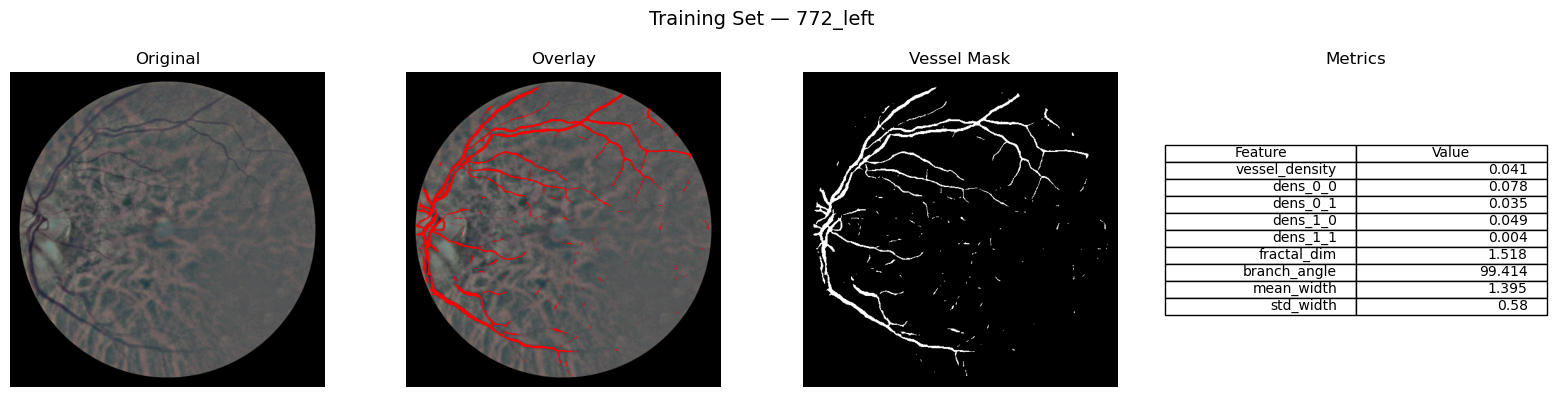

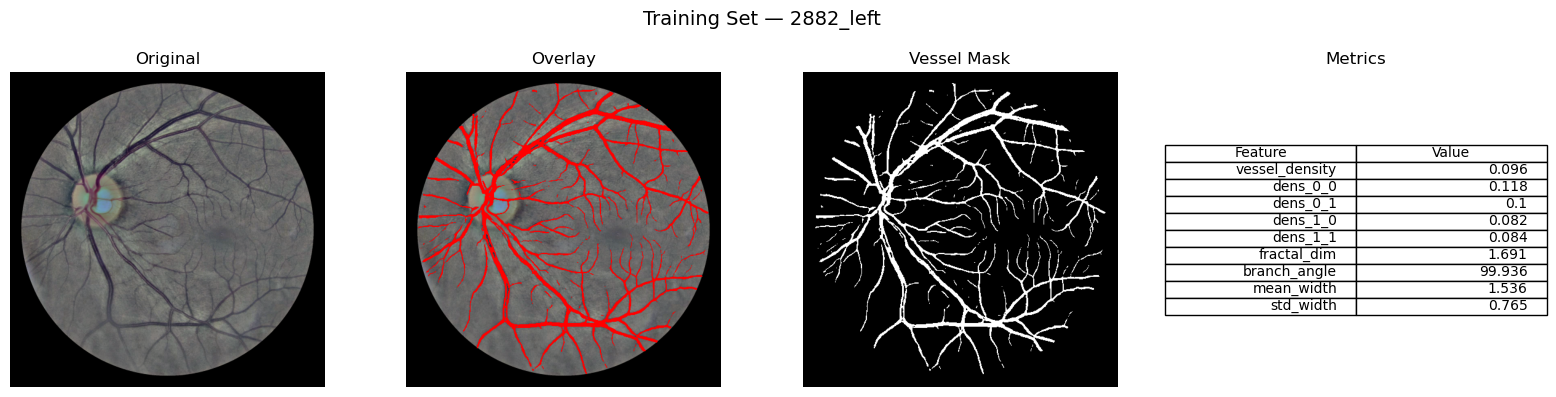

In [210]:
# ---------------- Visualization (with _pred look-up) ----------------
for split in SPLITS:
    subset = df[df["dataset"] == split]
    if subset.empty:
        continue
    # pick up to two random samples
    samples = subset.sample(n=min(2, len(subset)), random_state=42)
    
    img_folder = BASE_DIR / split / "images"
    ves_folder = BASE_DIR / split / "Vessel_Images"
    
    for _, row in samples.iterrows():
        name = row["name"]
        # load original fundus
        orig_path = img_folder / f"{name}.png"
        orig = cv2.imread(str(orig_path))[:, :, ::-1]  # BGR→RGB
        
        # load vessel mask (with _pred suffix)
        mask_path = ves_folder / f"{name}_pred.png"
        if not mask_path.exists():
            # fallback if naming differs
            candidates = list(ves_folder.glob(f"{name}*.png"))
            mask_path = candidates[0] if candidates else None
        
        if mask_path is None:
            print(f"[Warning] No mask found for {name}")
            continue
        
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE) > 0
        
        # build overlay & mask‐RGB
        overlay = orig.copy()
        overlay[mask, :] = [255, 0, 0]         # red vessels
        vessels = np.dstack([mask*255]*3)      # white mask
        
        # plot
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        axes[0].imshow(orig)
        axes[0].set_title("Original")
        axes[0].axis("off")
        
        axes[1].imshow(overlay)
        axes[1].set_title("Overlay")
        axes[1].axis("off")
        
        axes[2].imshow(vessels)
        axes[2].set_title("Vessel Mask")
        axes[2].axis("off")
        
        # feature table
        feats = row.drop(["dataset", "name"])
        cell_text = [[k, round(feats[k], 3)] for k in feats.index]
        tbl = axes[3].table(
            cellText=cell_text,
            colLabels=["Feature", "Value"],
            loc="center"
        )
        axes[3].axis("off")
        axes[3].set_title("Metrics")
        
        plt.suptitle(f"{split} — {name}", fontsize=14)
        plt.tight_layout()
        plt.show()

# Optic Disc and Fovea Localization - WIP 

In [226]:
# Use intensity-based heuristics or lightweight object detection to identify key landmarks
# ---------------- Settings ----------------
BASE_DIR = Path(r"C:\Users\ioana\Documents\VS Projects\Quantitative-Big-Immaging-Project\Datasets\OIA-ODIR-pre-2")
SPLITS   = ["Training Set", "Off-site Test Set", "On-site Test Set"]

# ---------------- Detection & Stats ----------------
records = []

In [227]:
from skimage.morphology import skeletonize

# ───────── Helpers ─────────────────────────────────────────────
def extract_circular_mask(img_bgr: np.ndarray):
    """Return mask of retina FOV and its center (cx, cy)."""
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    _, thr = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
    closed = cv2.morphologyEx(thr, cv2.MORPH_CLOSE, kernel)
    cnts, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(gray)
    cx = cy = None
    if cnts:
        cnt = max(cnts, key=cv2.contourArea)
        (x,y), r = cv2.minEnclosingCircle(cnt)
        cx, cy = int(x), int(y)
        cv2.circle(mask, (cx,cy), int(r), 255, -1)
    return mask>0, cx, cy

def fit_circle_and_stats(bin_mask: np.ndarray, intensity: np.ndarray):
    """Fit min‑enclosing circle to blob, compute center/radius and intensity stats."""
    b8 = (bin_mask.astype(np.uint8)*255)
    cnts, _ = cv2.findContours(b8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return {"cx":np.nan,"cy":np.nan,"r":np.nan,"mean_int":np.nan,"std_int":np.nan}
    cnt = max(cnts, key=cv2.contourArea)
    (x,y), rad = cv2.minEnclosingCircle(cnt)
    cx, cy, r = int(x), int(y), int(rad)
    h,w = intensity.shape
    yy, xx = np.ogrid[:h,:w]
    circ = (yy-cy)**2 + (xx-cx)**2 <= r*r
    vals = intensity[circ]
    return {
        "cx": cx, "cy": cy, "r": r,
        "mean_int": float(vals.mean()) if vals.size else np.nan,
        "std_int":  float(vals.std())  if vals.size else np.nan
    }

# ───────── Main Extraction ─────────────────────────────────────
BASE_DIR = Path(r"C:\Users\ioana\Documents\VS Projects\Quantitative-Big-Immaging-Project\Datasets\OIA-ODIR-pre-2")
SPLITS   = ["Training Set","Off-site Test Set","On-site Test Set"]

records = []
for split in SPLITS:
    img_dir = BASE_DIR/split/"images"
    ves_dir = BASE_DIR/split/"Vessel_Images"
    img_paths = sorted(sum([list(img_dir.glob(ext)) for ext in ("*.png","*.jpg")], []))
    
    for img_path in tqdm(img_paths, desc=split):
        stem = img_path.stem.lower()
        img = cv2.imread(str(img_path))
        if img is None: continue
        green = img[...,1]
        h,w = green.shape
        
        # 1) Fundus mask + vessels
        fundus, fcx, fcy = extract_circular_mask(img)
        if fcx is None: continue
        vmask = next(iter(ves_dir.glob(f"{img_path.stem}_pred.*")), None)
        if vmask is None: continue
        vessels = cv2.imread(str(vmask), cv2.IMREAD_GRAYSCALE) > 0
        
        # 2) Skeletonize vessels ∩ fundus, get junctions
        skel = skeletonize((vessels & fundus).astype(bool))
        deg  = cv2.filter2D(skel.astype(np.uint8), -1, np.ones((3,3),np.uint8)) - skel.astype(np.uint8)
        ys, xs = np.where(skel & (deg >= 2))
        
        
        # 3) Define halves on fundus
        mid_x = w//2
        arr_x = np.arange(w)[None,:]
        left  = fundus & (arr_x <  mid_x)
        right = fundus & (arr_x >= mid_x)
        if stem.endswith("left"):
            fv_reg, od_reg = left, right
            ref_pt = (fcy, fcx//2)

        elif stem.endswith("right"):
            fv_reg, od_reg = right, left
            ref_pt = (fcy, fcx + (w-fcx)//2)
        
        else:
            fv_reg = od_reg = fundus
            ref_pt = (fcy, fcx)
        
        # 4) Pick junction in fv_reg closest to ref_pt
        in_reg = fv_reg[ys,xs]
        if in_reg.any():
            ys2, xs2 = ys[in_reg], xs[in_reg]
            d2 = (ys2-ref_pt[0])**2 + (xs2-ref_pt[1])**2
            i = np.argmin(d2)
            fv_y, fv_x = int(ys2[i]), int(xs2[i])
        else:
            fv_x = fv_y = None
        
        # 5) Local bright mask (radius 0.2, threshold 85th pct)
        valid = fundus & ~vessels
        if fv_x is not None:
            R = int(0.2*min(h,w))
            yy, xx = np.ogrid[:h,:w]
            local = (yy-fv_y)**2 + (xx-fv_x)**2 <= R*R
            vals = green.copy()
            vals[~(local & valid)] = 0
            if np.any(vals>0):
                th = np.percentile(vals[vals>0], 85)
                bin_fv = (green >= th) & local & valid
            else:
                bin_fv = np.zeros_like(fundus)
        else:
            bin_fv = np.zeros_like(fundus)
        fv = fit_circle_and_stats(bin_fv, green)
        
        # 6) Optic disc: darkest 10% in od_reg
        vals2 = green.copy()
        vals2[~od_reg] = 255
        if np.any(vals2<255):
            th2 = np.percentile(vals2[vals2<255], 10)
            bin_od = (green <= th2) & od_reg & valid
        else:
            bin_od = np.zeros_like(fundus)
        od = fit_circle_and_stats(bin_od, green)
        
        # 7) Record
        rec = {"dataset": split, "name": img_path.stem}
        rec.update({f"fv_{k}":v for k,v in fv.items()})
        rec.update({f"od_{k}":v for k,v in od.items()})
        records.append(rec)

df_fd = pd.DataFrame(records)
print("Extracted from", len(df_fd), "images")
df_fd.head()

On-site Test Set: 100%|██████████| 2000/2000 [00:34<00:00, 57.74it/s]


Extracted from 10000 images


,dataset,name,fv_cx,fv_cy,fv_r,fv_mean_int,fv_std_int,od_cx,od_cy,od_r,od_mean_int,od_std_int
0,Training Set,0_left,193,234,16,47.680050,5.619849,423,369,37,42.313767,9.222315
1,Training Set,0_right,377,245,21,119.670794,23.571144,237,288,47,98.188412,15.530239
2,Training Set,1005_left,141,200,22,111.335531,27.703323,299,272,16,79.436637,7.526286
3,Training Set,1005_right,377,252,20,116.428003,22.754889,198,277,13,88.735350,7.409051
4,Training Set,1006_left,44,257,17,128.185350,23.586760,285,260,29,115.527957,15.663968


In [228]:
df_fd.to_csv(BASE_DIR/"fovea_optic_dis_features.csv", index=False)

In [ ]:
# ---------------- Visualization (5 samples per split) ----------------
for split in SPLITS:
    if "dataset" in df_fd.columns:
        subset = df_fd[df_fd["dataset"] == split]
    else:
        subset = df_fd.copy()
    if subset.empty:
        continue

    # <-- sample 5 instead of 2 -->
    samples = subset.sample(n=min(5, len(subset)), random_state=42)
    img_folder = BASE_DIR / split / "images"
    
    for _, row in samples.iterrows():
        name = row["name"]
        orig = cv2.imread(str(img_folder / f"{name}.png"))[:, :, ::-1]
        h, w, _ = orig.shape
        
        overlay = orig.copy()
        mask_df = np.zeros((h, w, 3), dtype=np.uint8)
        
        # Optic Disc circle (green)
        od_x_f = row.get("od_cx", np.nan)
        od_y_f = row.get("od_cy", np.nan)
        od_r_f = row.get("od_r", np.nan)
        if not np.isnan(od_x_f):
            od_x, od_y, od_r = int(od_x_f), int(od_y_f), int(od_r_f)
            cv2.circle(overlay, (od_x, od_y), od_r, (0, 255, 0), 2)
            cv2.circle(mask_df,   (od_x, od_y), od_r, (255, 255, 255), -1)
        
        # Fovea circle (red)
        fv_x_f = row.get("fv_cx", np.nan)
        fv_y_f = row.get("fv_cy", np.nan)
        fv_r_f = row.get("fv_r", np.nan)
        if not np.isnan(fv_x_f):
            fv_x, fv_y, fv_r = int(fv_x_f), int(fv_y_f), int(fv_r_f)
            cv2.circle(overlay, (fv_x, fv_y), fv_r, (0, 0, 255), 2)
            cv2.circle(mask_df,   (fv_x, fv_y), fv_r, (127, 127, 127), -1)
        
        # Plot panels
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        axes[0].imshow(orig)
        axes[0].set_title("Original"); axes[0].axis("off")
        
        axes[1].imshow(overlay)
        axes[1].set_title("Overlay (OD=green, FV=red)"); axes[1].axis("off")
        
        axes[2].imshow(mask_df)
        axes[2].set_title("Detected Circles Mask"); axes[2].axis("off")
        
        # Metrics table
        metrics = {k: row[k] for k in row.index if k not in ("dataset", "name")}
        cell_text = [[k, round(metrics[k], 3)] for k in metrics]
        axes[3].table(cellText=cell_text,
                      colLabels=["Feature", "Value"],
                      loc="center")
        axes[3].axis("off")
        axes[3].set_title("Circle Fit Stats")
        
        plt.suptitle(f"{split} — {name}", fontsize=14)
        plt.tight_layout()
        plt.show()

# Opacity - WIP


In [230]:
# Analyze texture patterns (entropy, blurring) in central fundus to detect cataract-related features.
BASE_DIR = Path(r"C:\Users\ioana\Documents\VS Projects\Quantitative-Big-Immaging-Project\Datasets\OIA-ODIR-pre-2")
SPLITS   =  ["Training Set", "Off-site Test Set", "On-site Test Set"]

records = []

In [231]:
# ───────── Helper ──────────────────────────────────────────────
def extract_circular_mask(img_bgr: np.ndarray) -> np.ndarray:
    """Return a boolean mask of the retinal field‐of‐view (fundus disk)."""
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    _, thr = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
    closed = cv2.morphologyEx(thr, cv2.MORPH_CLOSE, kernel)
    cnts, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(gray, dtype=bool)
    if cnts:
        cnt = max(cnts, key=cv2.contourArea)
        (x,y), r = cv2.minEnclosingCircle(cnt)
        yy, xx = np.ogrid[:gray.shape[0], :gray.shape[1]]
        mask = (yy - int(y))**2 + (xx - int(x))**2 <= int(r)**2
    return mask

# ───────── Texture Analysis ───────────────────────────────────
for split in SPLITS:
    img_dir = BASE_DIR / split / "images"
    for img_path in tqdm(sorted(img_dir.glob("*.png")), desc=f"Analyzing Texture {split}", unit="img"):
        name = img_path.stem
        # load color and grayscale
        img_bgr = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
        if img_bgr is None:
            continue
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        h, w = gray.shape

        # fundus field-of-view mask
        fundus_mask = extract_circular_mask(img_bgr)

        # central circular ROI (50% of min dimension)
        cy, cx = h//2, w//2
        r_roi = int(0.3 * min(h, w))
        yy, xx = np.ogrid[:h, :w]
        central_circle = (yy - cy)**2 + (xx - cx)**2 <= r_roi**2

        # restrict to fundus (exclude background)
        roi_mask = fundus_mask & central_circle

        # extract pixel values within masked ROI
        vals = gray[roi_mask]
        if vals.size == 0:
            entropy = np.nan
            blur_var = np.nan
        else:
            # Shannon entropy
            hist = np.bincount(vals, minlength=256).astype(np.float64)
            prob = hist / hist.sum()
            prob = prob[prob > 0]
            entropy = float(-np.sum(prob * np.log2(prob)))

            # Blurriness: variance of Laplacian in ROI
            lap = cv2.Laplacian(gray, cv2.CV_64F)
            blur_var = float(np.var(lap[roi_mask]))

        records.append({
            "dataset": split,
            "name":      name,
            "central_entropy":    entropy,
            "central_blur_var":   blur_var
        })

# build dataframe  
df_tex = pd.DataFrame(records)
print("Computed texture on", len(df_tex), "images")
df_tex.head(10)

Analyzing Texture On-site Test Set: 100%|██████████| 2000/2000 [00:12<00:00, 159.10img/s]

Computed texture on 10000 images


,dataset,name,central_entropy,central_blur_var
0,Training Set,0_left,4.620176,224.197872
1,Training Set,0_right,5.422172,148.323924
2,Training Set,1005_left,5.262451,122.931017
3,Training Set,1005_right,5.286256,120.611019
4,Training Set,1006_left,5.399187,560.581294
5,Training Set,1006_right,5.301177,373.323704
6,Training Set,1008_left,5.408030,113.206719
7,Training Set,1008_right,5.452646,155.208000
8,Training Set,100_left,5.597082,189.293302
9,Training Set,100_right,5.882657,278.193463


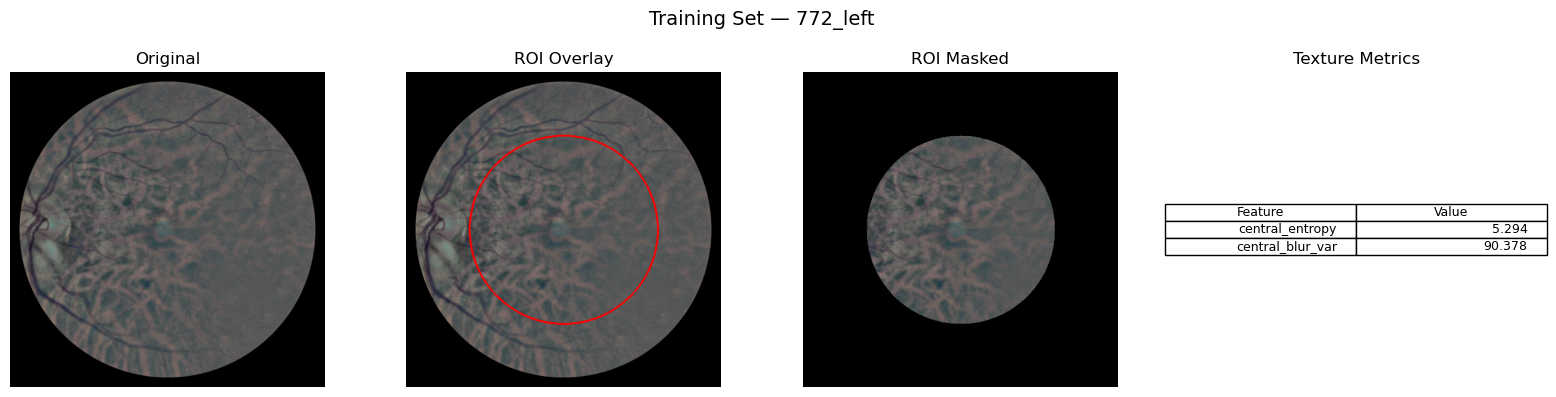

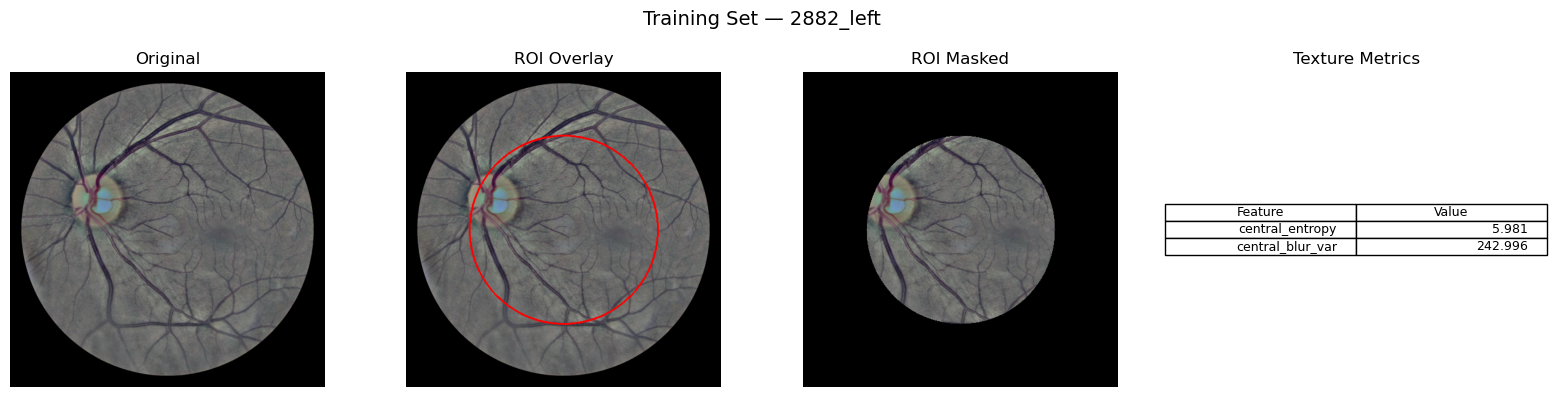

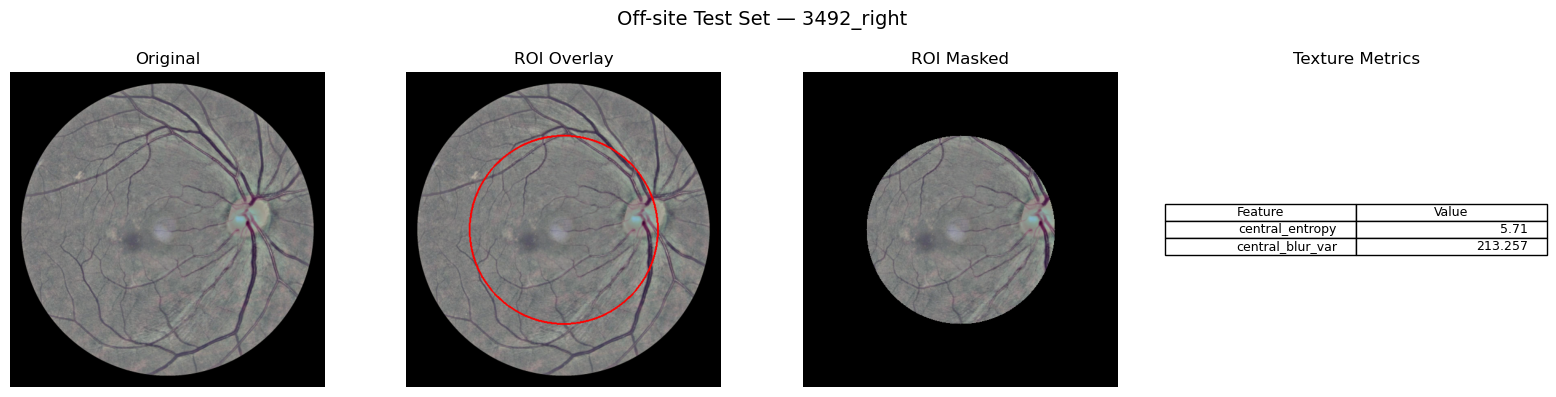

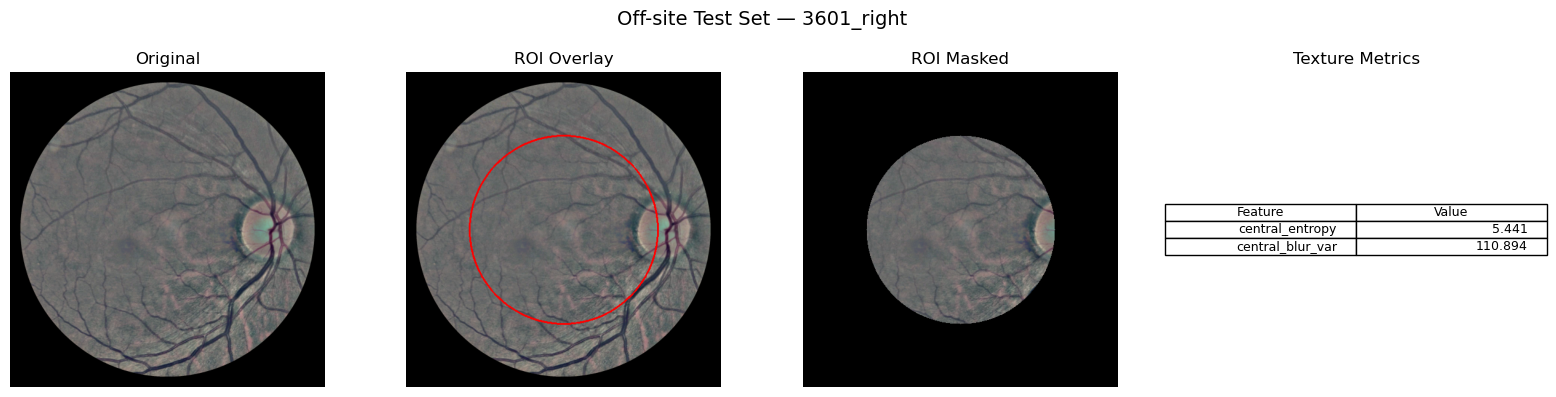

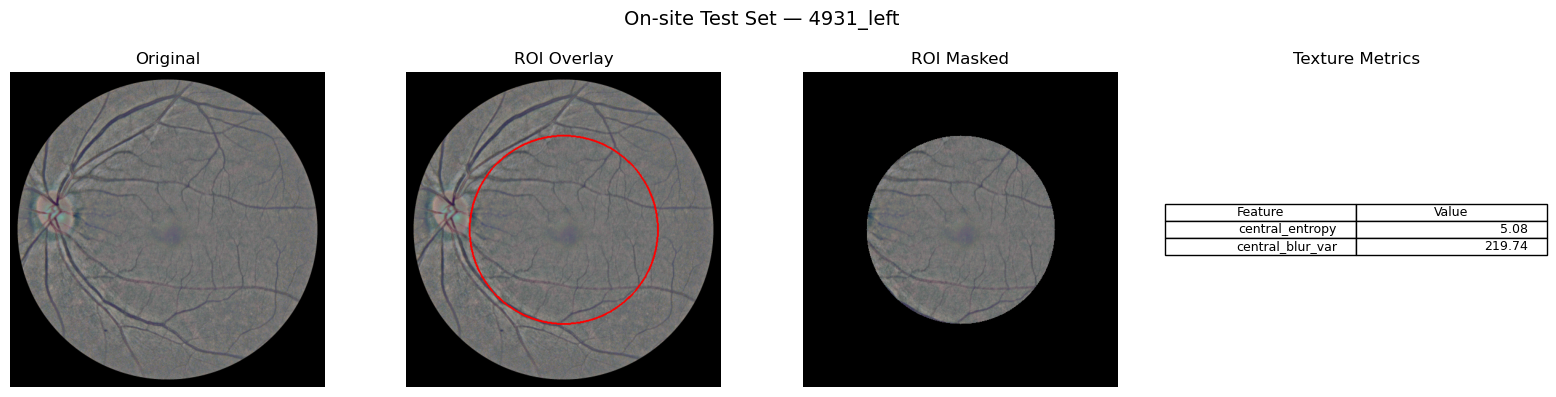

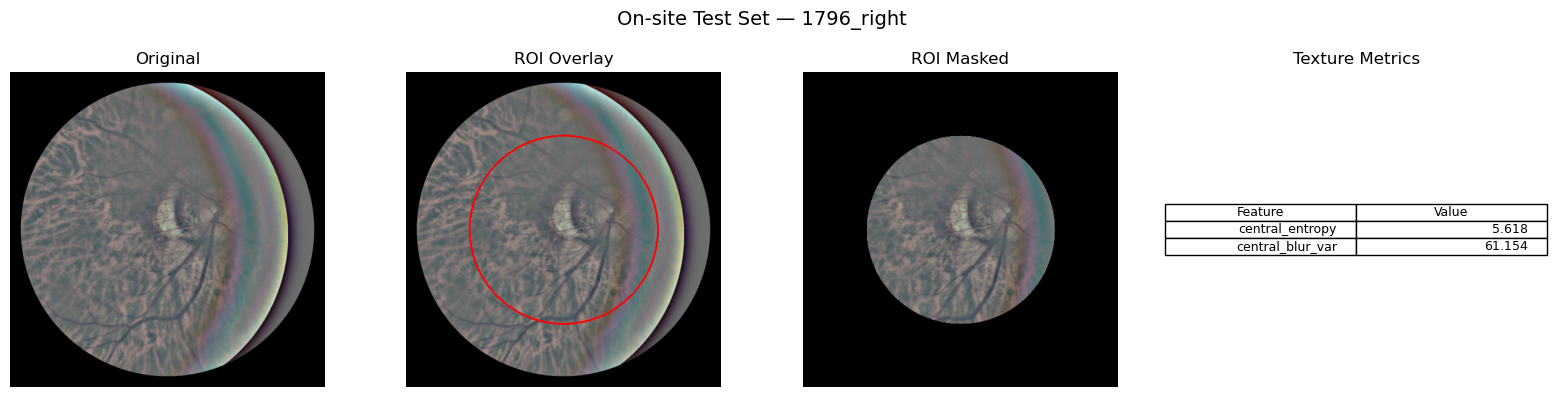

In [ ]:
for split in SPLITS:
    # Safely filter by dataset column if it exists
    if 'dataset' in df_tex.columns:
        subset = df_tex[df_tex['dataset'] == split]
    else:
        subset = df_tex.copy()
    if subset.empty:
        continue
    
    samples = subset.sample(n=min(2, len(subset)), random_state=42)
    img_folder = BASE_DIR / split / "images"
    
    for _, row in samples.iterrows():
        name = row.get('name')
        # Load original
        img_path = img_folder / f"{name}.png"
        orig = cv2.imread(str(img_path))[:, :, ::-1]
        h, w = orig.shape[:2]
        
        # Central ROI parameters
        cy, cx = h//2, w//2
        r_roi = int(min(h, w) * 0.3)
        yy, xx = np.ogrid[:h, :w]
        roi_mask = (yy - cy)**2 + (xx - cx)**2 <= r_roi**2
        
        # Overlay circle
        overlay = orig.copy()
        cv2.circle(overlay, (cx, cy), r_roi, (255, 0, 0), 2)
        
        # ROI-only image
        roi_img = orig.copy()
        roi_img[~roi_mask] = 0
        
        # Prepare metrics table
        drop_cols = [c for c in ['dataset', 'name'] if c in row.index]
        feats = row.drop(drop_cols)
        cell_text = [[k, round(feats[k], 3)] for k in feats.index]
        
        # Plotting
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        axes[0].imshow(orig)
        axes[0].set_title("Original")
        axes[0].axis("off")
        
        axes[1].imshow(overlay)
        axes[1].set_title("ROI Overlay")
        axes[1].axis("off")
        
        axes[2].imshow(roi_img)
        axes[2].set_title("ROI Masked")
        axes[2].axis("off")
        
        tbl = axes[3].table(
            cellText=cell_text,
            colLabels=["Feature", "Value"],
            loc="center"
        )
        axes[3].axis("off")
        axes[3].set_title("Texture Metrics")
        
        plt.suptitle(f"{split} — {name}", fontsize=14)
        plt.tight_layout()
        plt.show()

In [233]:
df_tex.to_csv(BASE_DIR/"texture_features.csv", index=False)